# Import module and important variable

In [1]:
#!jupyter nbconvert --to script model_build.ipynb

import os
#import own module

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
import copy
import psutil
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle
import random
import sys
import time
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from statistics import mean
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
# from attention import Attention
# from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from scipy import stats
from datetime import datetime
from time import sleep
#from geopy import distance 


2023-03-20 01:49:17.346643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.__version__)

2.4.1


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2023-03-20 01:49:19.655845: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-20 01:49:19.657151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-20 01:49:19.811091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-20 01:49:19.811876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-20 01:49:19.812626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:88:0

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5709092930970974261,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10565736192
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5408910908152234741
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10565736192
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3134007847179557665
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5",
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10565736192
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 2695387037007186655
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:88:00.0, compute capability: 7.5",
 name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 1

dwidth: 573.69GiB/s
2023-03-20 01:49:19.813364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 3 with properties: 
pciBusID: 0000:89:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-20 01:49:19.814105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 4 with properties: 
pciBusID: 0000:b1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-20 01:49:19.814132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-20 01:49:19.816825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-20 01:49:19.816883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully

In [4]:
# #check current ram used if needed
# print('Total Ram (GB):', psutil.virtual_memory()[0]/1000000000)
# print('Available (GB):', psutil.virtual_memory()[1]/1000000000)
# print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
# print('RAM memory % used:', psutil.virtual_memory()[2])
# psutil.virtual_memory()

In [5]:
TASK_TYPE = ['DPT', 'MA', 'PVT', 'VWM']
RUN_TYPE = ['All_task','DPT', 'MA', 'PVT', 'VWM']
#NORMALIZE_FEATURES = ['Pupil Diameter', 'Pupil X', 'Pupil Y']
NORMALIZE_FEATURES = ['Pupil Diameter']
TIME_INTERVAL_EACH_SAMPLE = 1
NUMBER_OF_TIME_SAMPLE = 250 * TIME_INTERVAL_EACH_SAMPLE
NUMBER_OF_CHANNELS = 10
NUMBER_OF_INTERVAL_EACH_CHANNEL = NUMBER_OF_TIME_SAMPLE//NUMBER_OF_CHANNELS

In [6]:
CURRENT_TASK = RUN_TYPE[0]
RUN = 'run9_CNN_pupil_drop_data/' + CURRENT_TASK+'/'
MODEL_NAME = 'Inception_1D'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/common/data/
/nfs/ada/jbrook1/common/output/run9_CNN_pupil_drop_data/All_task/


# Preprocessing

## Load data

In [7]:
behavior_df = pd.read_pickle(DATA_DIR + 'behavior_data.pickle')
behavior_df

,Task Type,SID,Trial,Stimulus Time,Reaction Time,isCorrectResponse
0,DPT,0,0,1.402413,605.970,1.0
1,DPT,0,0,4.852193,486.175,1.0
2,DPT,0,0,8.401990,443.381,1.0
3,DPT,0,0,11.735102,546.256,1.0
4,DPT,0,0,15.518205,487.143,1.0
...,...,...,...,...,...,...
112195,VWM,57,7,220.884844,322.137,1.0
112196,VWM,57,7,228.184393,379.615,1.0
112197,VWM,57,7,235.350625,352.227,1.0
112198,VWM,57,7,243.966769,353.536,1.0


In [8]:
eye_df = pd.read_pickle(DATA_DIR + 'eye_data.pickle')
eye_df

,Task Type,SID,Trial,Time,Pupil Diameter,Pupil X,Pupil Y
0,DPT,0,0,0.004,5.884283,652.900024,223.100006
1,DPT,0,0,0.008,5.884123,652.799988,223.300003
2,DPT,0,0,0.012,5.883903,653.299988,223.800003
3,DPT,0,0,0.016,5.883621,653.799988,224.399994
4,DPT,0,0,0.020,5.883276,653.400024,224.699997
...,...,...,...,...,...,...,...
157740006,VWM,57,7,274.820,2.233881,554.400024,395.899994
157740007,VWM,57,7,274.824,2.233667,551.400024,399.000000
157740008,VWM,57,7,274.828,2.234875,551.700012,394.899994
157740009,VWM,57,7,274.832,2.237447,550.799988,403.799988


## Interpolation

Total number of data         : 157,740,011  
Total number of missing data :  29,124,939  
Only missing on Pupil X and Pulpil X. Pupil Diameter is already interpolate  
Consecutive missing data describe:  
Count:&emsp;29124939  
Mean:&emsp;728.6144  
Std :&emsp;2694.344  
Min :&emsp;1  
25% :&emsp;32  
50% :&emsp;143  
75% :&emsp;659  
Max :&emsp;71997  

In [9]:
#eye_df.isna().sum()

#This code will get the consecutive missing data 
#temp = eye_df['Pupil X'].isnull().astype(int).groupby(eye_df['Pupil X'].notnull().astype(int).cumsum()).cumsum()

## Normalizing Feature Data

In [10]:
def Fit_data(type_of_scaler, list_of_features, eye_data):
    scaler = {}
    for feature in tqdm(list_of_features, desc='Normalizing Data'):
        current_data = eye_data[feature]
        scaler[feature] = type_of_scaler().fit(np.array(current_data).reshape(-1,1))
    return scaler

def Transform_data(scaler, list_of_features, eye_data):
    eye_data_scaled = copy.copy(eye_data)
    
    for feature in tqdm(list_of_features, desc='Normalizing Data'):
        current_data = eye_data[feature]
        scaled_data = scaler[feature].transform(np.array(current_data).reshape(-1,1))
        eye_data_scaled[feature] = scaled_data
        
    return eye_data_scaled

In [11]:
scaler = Fit_data(StandardScaler, NORMALIZE_FEATURES, eye_df)
eye_df_scaled = Transform_data(scaler,NORMALIZE_FEATURES, eye_df)
eye_df_scaled

Normalizing Data:   0%|          | 0/3 [00:00<?, ?it/s]

Normalizing Data:   0%|          | 0/3 [00:00<?, ?it/s]

,Task Type,SID,Trial,Time,Pupil Diameter,Pupil X,Pupil Y
0,DPT,0,0,0.004,2.014614,1.228511,-1.238277
1,DPT,0,0,0.008,2.014439,1.227608,-1.236659
2,DPT,0,0,0.012,2.014198,1.232125,-1.232612
3,DPT,0,0,0.016,2.013889,1.236642,-1.227757
4,DPT,0,0,0.020,2.013511,1.233028,-1.225329
...,...,...,...,...,...,...,...
157740006,VWM,57,7,274.820,-1.983777,0.338654,0.160170
157740007,VWM,57,7,274.824,-1.984012,0.311551,0.185258
157740008,VWM,57,7,274.828,-1.982688,0.314262,0.152078
157740009,VWM,57,7,274.832,-1.979871,0.306131,0.224104


In [12]:
print(NORMALIZE_FEATURES)
for variable in NORMALIZE_FEATURES:
    print(scaler[variable].mean_)

['Pupil Diameter', 'Pupil X', 'Pupil Y']
[4.04500518]
[516.91381362]
[376.10845024]


## Generate X and Y sample

In [15]:
eye_df_scaled = eye_df_scaled.drop(['Pupil X','Pupil Y'],axis=1)

KeyError: "['Pupil X', 'Pupil Y'] not found in axis"

In [30]:
def Generate_X_Y_sample(TYPE_OF_TASK, SUBJECT_BEGIN, SUBJECT_END, NUMBER_OF_TRIAL, NUMBER_TO_GENERATE,
                        behaviour_data, eye_data):
    behavior_grouped = behaviour_data.groupby(['Task Type', 'SID', 'Trial'])
    eye_grouped = eye_data.groupby(['Task Type', 'SID', 'Trial'])

    X = []
    Y = []
    for task_type in tqdm(TYPE_OF_TASK, desc='Task_type'):
        #if task_type != CURRENT_TASK or CURRENT_TASK  != 'All_task':
        #    continue
        #for each task_type
        for sid in tqdm(range(SUBJECT_BEGIN, SUBJECT_END), desc='Subject ID'):
            #for each subject id
            for i in range(NUMBER_OF_TRIAL):
                #for each trial
                
                #if the data is not availible, it will raise an error
                try:
                    behavior_temp = behavior_grouped.get_group((task_type,sid,i))
                except:
                    continue
                eye_temp = eye_grouped.get_group((task_type,sid,i))

                for j in behavior_temp['Stimulus Time']:
                    #for each stimulus time, j is the stimulus time
                    for k in range(NUMBER_TO_GENERATE):
                        # k is the number of sample to generate after the time j
                        # the first samples is a positive sample, all sample after the first will the the negative sample

                        ###########################
                        #This code will generate X#
                        ###########################
                        begin = j + k*TIME_INTERVAL_EACH_SAMPLE
                        end = begin + TIME_INTERVAL_EACH_SAMPLE
                        eye_temp2 = eye_temp.query('Time >= @begin and Time <= @end')[NORMALIZE_FEATURES]
                        if eye_temp2.shape[0] == 0:
                            #This is an empty case
                            continue

                        if eye_temp2.isna().sum().sum() != 0:
                            #This is an missing data case, drop the sample
                            continue

                        if eye_temp2.shape[0] == NUMBER_OF_TIME_SAMPLE + 1:
                            #this is an extra sample case, drop the last one
#                             print(eye_temp2.shape, ' sid:', sid, ' i:', i, ' j:', j)
                            eye_temp2 = eye_temp2.drop(eye_temp2.tail(1).index)

                        #this code to cut the sample into smaller channels
                        #if NUMBER_OF_CHANNELS = 10, shape: (250,3,1) -> (25,3,10)
                        eye_temp3 = []
#                         for l in range(NUMBER_OF_CHANNELS):
#                             #for each channel loop
#                             begin_l = l*NUMBER_OF_INTERVAL_EACH_CHANNEL
#                             end_l = begin_l + NUMBER_OF_INTERVAL_EACH_CHANNEL
#                             eye_temp3.append(eye_temp2[begin_l:end_l])
#                             #end l loop
#                         eye_temp2 = np.array(eye_temp3).swapaxes(0,2).swapaxes(0,1)
                        
                        X.append(eye_temp2[['Pupil Diameter']])

                        ###########################
                        #This code will generate Y#
                        ###########################
                        if k == 0:
                            Y_temp = [1]
                        else:
                            Y_temp = [0]
                        Y.append(Y_temp)

                        #end k loop
                    # end j loop
                #end i loop
            #end sid loop
        #end task_type loop

    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [31]:
#abnormal shape: (251, 7) and (0, 7)
X_final, Y_final = Generate_X_Y_sample(TASK_TYPE, 0, 53, 10, 3, behavior_df, eye_df_scaled)

Task_type:   0%|          | 0/4 [00:00<?, ?it/s]

Subject ID:   0%|          | 0/53 [00:00<?, ?it/s]

KeyError: "['Pupil X', 'Pupil Y'] not in index"

In [22]:
print(X_final.shape)
X_final[0]

(0,)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [23]:
print(Y_final.shape)
Y_final[:5]

(0,)


array([], dtype=float64)

In [50]:
X_test, Y_test = Generate_X_Y_sample(TASK_TYPE, 53, 58, 10, 3, behavior_df, eye_df_scaled)

Task_type:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [51]:
print(X_test.shape)
X_test

(1712, 250)


array([[0.19998531, 0.19847536, 0.19697063, ..., 0.63359499, 0.63727194,
        0.64104081],
       [0.64490003, 0.64884492, 0.65287128, ..., 0.97220208, 0.97605922,
        0.9799033 ],
       [0.16523869, 0.16394445, 0.16257447, ..., 0.45081523, 0.45637817,
        0.46196672],
       ...,
       [0.68376703, 0.68625158, 0.6887659 , ..., 0.34456557, 0.34473688,
        0.34492804],
       [2.41241455, 2.40858509, 2.40499954, ..., 2.08343071, 2.08396868,
        2.08349705],
       [2.08212811, 2.08043066, 2.07888989, ..., 2.07458358, 2.07334157,
        2.07210896]])

In [52]:
print(Y_test.shape)
Y_test[:5]

(1712, 1)


array([[1],
       [0],
       [1],
       [0],
       [1]])

## Split

In [53]:
X_train,X_val,Y_train,Y_val = train_test_split(X_final,Y_final,test_size=0.2, random_state=96, shuffle=True)

In [54]:
# X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
# X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],X_val.shape[2],1))
# X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))

In [55]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(1369, 250)
(343, 250)
(1712, 250)
(1369, 1)
(343, 1)
(1712, 1)


In [56]:
output = []

#statistic
output.append("Training set:")
output.append("Number of positive element: " +  str(np.count_nonzero(Y_train)))
output.append("The ratio: " + str(np.count_nonzero(Y_train)/Y_train.shape[0]))

output.append("\nValidation set:")
output.append("Number of positive element: " + str(np.count_nonzero(Y_val)))
output.append("The ratio: " + str(np.count_nonzero(Y_val)/Y_val.shape[0]))

output.append("\nTesting set:")
output.append("Number of positive element: " + str(np.count_nonzero(Y_test)))
output.append("The ratio: " + str(np.count_nonzero(Y_test)/Y_test.shape[0]))
output.append("\n")


for string in output:
    print(string)


Training set:
Number of positive element: 545
The ratio: 0.3981008035062089

Validation set:
Number of positive element: 126
The ratio: 0.3673469387755102

Testing set:
Number of positive element: 671
The ratio: 0.3919392523364486




# CNN model

In [57]:
#hyper parameter
PATIENCE=10
KERNEL_SIZE =  (3,3)
STRIDES_SIZE = (1,1)
MAX_POOL =  (2,1)
DROPOUT = 0.3
EPOCHS = 100
BATCH_SIZE = 128

In [58]:
# #Custom Layers
# class My_Ave_Layer(tf.keras.layers.Layer):
#     def __init__(self,dims):
#         super(My_Ave_Layer, self).__init__()
#         self.units = 1
#         self.dims = dims
# #     def build(self, input_shape):
# #         self.kernel = self.add_weight("kernel",
# #                                   shape=[int(input_shape[-1]),
# #                                          self.num_outputs])

#     def compute_output_shape(self, input_shape):
#         input_shape = tf.TensorShape(input_shape)
#         input_shape = input_shape.with_rank_at_least(2)
#         return input_shape[:-1].concatenate(self.units)
    
    
#     def call(self, inputs):
#         input_no_grad = tf.stop_gradient(inputs)
#         compute_dim = tuple(range(1,self.dims))
#         #compute_dim = tuple(range(1,3))
#         ave = tf.math.reduce_sum(inputs,axis=compute_dim)/tf.cast(tf.reduce_prod(input_no_grad.get_shape()[1:]), dtype=tf.float32)
#         return tf.reshape(ave,shape=(-1,1))
    

    
    

    
# #testing

# sample = tf.constant([[[0,1,2,3],[0,1,2,3],[0,1,2,3]],[[10,10,10,10],[10,10,10,10],[10,10,10,10]]],shape=(2,3,4), dtype=tf.float32)
# inp = tf.keras.Input(shape=(3,4))
# out = My_Ave_Layer(3)(inp)
# model = tf.keras.Model(inp, out)

# output = model.predict(sample)
# output

In [59]:
# Custom Callback


N = 0
#current_lr = 0.00002
class print_learning_rate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        #lr = tf.keras.backend.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        #print('\nLearning Rate: {:.6f}\n'.format(lr))
        lr = float(tf.keras.backend.get_value(optimizer.lr))
        decay = float(tf.keras.backend.get_value(optimizer.decay))
        iterations = float(tf.keras.backend.get_value(optimizer.iterations))
        print('\nLearning Rate: {:.10f}. Decay: {:.10f}. Iteration: {:.10f}\n'.format(lr,decay,iterations))
        
class adjust_learning_rate(tf.keras.callbacks.Callback):   
    def on_epoch_begin(self, epoch, logs={}):
        #first element is epochs, second is new lr
        LR_Table = [
        #(0,current_lr),
        (25 - N, 0.0003),
        (50 - N, 0.0001),
        (75 - N, 0.00003),
        (100 - N, 0.00002),
        (125 - N, 0.00001),]

        if epoch >= LR_Table[0][0] and epoch <= LR_Table[-1][0]:
            for i in range(len(LR_Table)):
                if epoch == LR_Table[i][0]:
                    newlr = LR_Table[i][1]
                    tf.keras.backend.set_value(self.model.optimizer.lr, newlr)
                    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                    print("\nEpoch {}: The New learning rate is {:.6f}.".format(epoch, lr))
                    

def checkpoint_save_weights():
    return tf.keras.callbacks.ModelCheckpoint(OUTPUT_DIR+'model_save/', save_weights_only=True, verbose = 1,save_freq='epoch')


cb_print_learning_rate = print_learning_rate()
cb_adjust_learning_rate = adjust_learning_rate()   
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.0001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True)

In [64]:
#create model
def create_2D_CNN_model(shape, kernel_size, strides_size, max_pool_size, dropout=0.3):
    
    input_layer = tf.keras.Input((shape[1], shape[2], shape[3]))
    
    conv_1 = tf.keras.layers.Conv2D(64, kernel_size, strides=strides_size,  padding='same', activation='relu',)(input_layer)
    conv_1 = tf.keras.layers.MaxPool2D(max_pool_size,  padding='same')(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv2D(128, kernel_size, strides=strides_size, padding='same', activation='relu',)(conv_1)
    conv_2 = tf.keras.layers.MaxPool2D(max_pool_size,  padding='same')(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    conv_3 = tf.keras.layers.Conv2D(256, kernel_size, strides=strides_size, padding='same', activation='relu',)(conv_2)
    conv_3 = tf.keras.layers.MaxPool2D(max_pool_size,  padding='same')(conv_3)
    conv_3 = tf.keras.layers.Dropout(dropout)(conv_3)     
    
    dense_1 = tf.keras.layers.Flatten()(conv_3)
    dense_1 = tf.keras.layers.Dense(32)(dense_1)
    
    output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(dense_1)
    
    model = tf.keras.Model(input_layer, output_layer)
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    return model

def create_1D_CNN_model(shape, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3):
    
    input_layer = tf.keras.Input((shape[1], shape[2]))
    
    conv_1 = tf.keras.layers.Conv1D(64, kernel_size, strides=strides_size,  padding='same', activation='relu',)(input_layer)
    conv_1 = tf.keras.layers.MaxPool1D(max_pool_size,  padding='same')(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv1D(128, kernel_size, strides=strides_size, padding='same', activation='relu',)(conv_1)
    conv_2 = tf.keras.layers.MaxPool1D(max_pool_size,  padding='same')(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    conv_3 = tf.keras.layers.Conv1D(256, kernel_size, strides=strides_size, padding='same', activation='relu',)(conv_2)
    conv_3 = tf.keras.layers.MaxPool1D(max_pool_size,  padding='same')(conv_3)
    conv_3 = tf.keras.layers.Dropout(dropout)(conv_3)     
    
    dense_1 = tf.keras.layers.Flatten()(conv_3)
    dense_1 = tf.keras.layers.Dense(32)(dense_1)
    
    output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(dense_1)
    
    model = tf.keras.Model(input_layer, output_layer)
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    return model

def create_1D_u_net(SHAPE,start_neuron = 9, KERNEL_SIZE = 5, dropout=0.3):
        input_layer = tf.keras.Input((SHAPE[1], SHAPE[2]))
        
        conv1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size=KERNEL_SIZE,padding='same')(input_layer)
        conv1 = tf.keras.layers.Dropout(dropout)(conv1)
        conv1 = tf.keras.layers.BatchNormalization()(conv1)
        conv1 = tf.keras.layers.Activation('relu')(conv1)
        conv1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size=KERNEL_SIZE,padding='same')(conv1)
        conv1 = tf.keras.layers.Dropout(dropout)(conv1)
        conv1 = tf.keras.layers.BatchNormalization()(conv1)
        conv1 = tf.keras.layers.Activation('relu')(conv1)
        pool1 = tf.keras.layers.MaxPool1D(2)(conv1)
        
        conv2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size=KERNEL_SIZE,padding='same')(pool1)
        conv2 = tf.keras.layers.Dropout(dropout)(conv2)
        conv2 = tf.keras.layers.BatchNormalization()(conv2)
        conv2 = tf.keras.layers.Activation('relu')(conv2)
        conv2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size=KERNEL_SIZE,padding='same')(conv2)
        conv2 = tf.keras.layers.Dropout(dropout)(conv2)
        conv2 = tf.keras.layers.BatchNormalization()(conv2)
        conv2 = tf.keras.layers.Activation('relu')(conv2)
        pool2 = tf.keras.layers.MaxPool1D(5)(conv2)
        
        conv3 = tf.keras.layers.Conv1D(start_neuron * 4, kernel_size=KERNEL_SIZE,padding='same')(pool2)
        conv3 = tf.keras.layers.Dropout(dropout)(conv3)
        conv3 = tf.keras.layers.BatchNormalization()(conv3)
        conv3 = tf.keras.layers.Activation('relu')(conv3)
        conv3 = tf.keras.layers.Conv1D(start_neuron * 4, kernel_size=KERNEL_SIZE,padding='same')(conv3)
        conv3 = tf.keras.layers.Dropout(dropout)(conv3)
        conv3 = tf.keras.layers.BatchNormalization()(conv3)
        conv3 = tf.keras.layers.Activation('relu')(conv3)
        pool3 = tf.keras.layers.MaxPool1D(5)(conv3)
        
        convm = tf.keras.layers.Conv1D(start_neuron * 8, kernel_size=KERNEL_SIZE,padding='same')(pool3)
        convm = tf.keras.layers.Dropout(dropout)(convm)
        convm = tf.keras.layers.BatchNormalization()(convm)
        convm = tf.keras.layers.Activation('relu')(convm)
        convm = tf.keras.layers.Conv1D(start_neuron * 8, kernel_size=KERNEL_SIZE,padding='same')(convm)
        convm = tf.keras.layers.Dropout(dropout)(convm)
        convm = tf.keras.layers.BatchNormalization()(convm)
        convm = tf.keras.layers.Activation('relu')(convm)
        
        deconv3 = tf.keras.layers.Conv1DTranspose(start_neuron * 4, kernel_size=KERNEL_SIZE,strides=5,padding='same')(convm)
        deconv3 = tf.keras.layers.concatenate([deconv3,conv3])
        
        unconv3 = tf.keras.layers.Conv1D(start_neuron * 4, kernel_size=KERNEL_SIZE,padding='same')(deconv3)
        unconv3 = tf.keras.layers.Dropout(dropout)(unconv3)
        unconv3 = tf.keras.layers.BatchNormalization()(unconv3)
        unconv3 = tf.keras.layers.Activation('relu')(unconv3)
        unconv3 = tf.keras.layers.Conv1D(start_neuron * 4, kernel_size=KERNEL_SIZE,padding='same')(unconv3)
        unconv3 = tf.keras.layers.Dropout(dropout)(unconv3)
        unconv3 = tf.keras.layers.BatchNormalization()(unconv3)
        unconv3 = tf.keras.layers.Activation('relu')(unconv3)

        deconv2 = tf.keras.layers.Conv1DTranspose(start_neuron * 2, kernel_size=KERNEL_SIZE,strides=5,padding='same')(unconv3)
        deconv2 = tf.keras.layers.concatenate([deconv2,conv2])
        
        unconv2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size=KERNEL_SIZE,padding='same')(deconv2)
        unconv2 = tf.keras.layers.Dropout(dropout)(unconv2)
        unconv2 = tf.keras.layers.BatchNormalization()(unconv2)
        unconv2 = tf.keras.layers.Activation('relu')(unconv2)
        unconv2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size=KERNEL_SIZE,padding='same')(unconv2)
        unconv2 = tf.keras.layers.Dropout(dropout)(unconv2)
        unconv2 = tf.keras.layers.BatchNormalization()(unconv2)
        unconv2 = tf.keras.layers.Activation('relu')(unconv2)    
        
        deconv1 = tf.keras.layers.Conv1DTranspose(start_neuron * 1, kernel_size=KERNEL_SIZE,strides=2,padding='same')(unconv2)
        deconv1 = tf.keras.layers.concatenate([deconv1,conv1])
        
        unconv1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size=KERNEL_SIZE,padding='same')(deconv1)
        unconv1 = tf.keras.layers.Dropout(dropout)(unconv1)
        unconv1 = tf.keras.layers.BatchNormalization()(unconv1)
        unconv1 = tf.keras.layers.Activation('relu')(unconv1)  
        unconv1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size=KERNEL_SIZE,padding='same')(unconv1)
        unconv1 = tf.keras.layers.Dropout(dropout)(unconv1)
        unconv1 = tf.keras.layers.BatchNormalization()(unconv1)
        unconv1 = tf.keras.layers.Activation('relu')(unconv1)        
        
        output_layer = tf.keras.layers.Conv1D(1, kernel_size=1, padding='same',activation='relu')(unconv1) 
        output_layer = tf.keras.layers.Flatten()(output_layer)
        output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(output_layer)
        
        model = tf.keras.Model(input_layer, output_layer)
        model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
        return model

    
    
    
def inception_layer(input_layer, filters_1x1, filters_3x3_reduce, filters_3x3, 
                    filters_5x5_reduce, filters_5x5, filters_pool):

    conv_1x1 = tf.keras.layers.Conv1D(filters_1x1, kernel_size=1, padding='same', activation='relu')(input_layer)
    
    conv_3x3 = tf.keras.layers.Conv1D(filters_3x3_reduce, kernel_size=1, padding='same', activation='relu')(input_layer)
    conv_3x3 = tf.keras.layers.Conv1D(filters_3x3, kernel_size=3, padding='same', activation='relu')(conv_3x3)
    
    conv_5x5 = tf.keras.layers.Conv1D(filters_5x5_reduce, kernel_size=1, padding='same', activation='relu')(input_layer)
    conv_5x5 = tf.keras.layers.Conv1D(filters_5x5, kernel_size=5, padding='same', activation='relu')(conv_5x5)
    
    pool = tf.keras.layers.MaxPool1D(3,strides=1,padding='same')(input_layer)
    pool = tf.keras.layers.Conv1D(filters_pool, kernel_size=1, padding='same', activation='relu')(pool)
    
    output = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool])
    return output
    
def create_1d_inception_(SHAPE, dropout=0.3):
    input_layer = tf.keras.Input((SHAPE[1], SHAPE[2]))

    incep_1 = inception_layer(input_layer, filters_1x1 = 6,
                              filters_3x3_reduce = 6, filters_3x3 = 12,
                              filters_5x5_reduce = 3, filters_5x5 = 3,
                              filters_pool = 3,
                             )
    
    incep_2 = tf.keras.layers.MaxPool1D(2)(incep_1)
    incep_2 = inception_layer(incep_2,filters_1x1 = 12,
                              filters_3x3_reduce = 12, filters_3x3 = 24,
                              filters_5x5_reduce = 3, filters_5x5 = 6,
                              filters_pool = 6,
                             )
    
    incep_3 = tf.keras.layers.MaxPool1D(2)(incep_2)
    residual_3 = tf.keras.layers.MaxPool1D(4)(input_layer)
    residual_3 = tf.keras.layers.concatenate([incep_3, residual_3],name='residual_3')
    incep_3 = inception_layer(residual_3,filters_1x1 = 24,
                              filters_3x3_reduce = 24, filters_3x3 = 48,
                              filters_5x5_reduce = 6, filters_5x5 = 12,
                              filters_pool = 12,
                             )
    
    incep_4 = tf.keras.layers.MaxPool1D(2)(incep_3)
    incep_4 = inception_layer(incep_4,filters_1x1 = 48,
                              filters_3x3_reduce = 48, filters_3x3 = 96,
                              filters_5x5_reduce = 12, filters_5x5 = 24,
                              filters_pool = 24,
                             )
    
    incep_5 = tf.keras.layers.MaxPool1D(2)(incep_4)
    incep_5 = inception_layer(incep_5,filters_1x1 = 96,
                              filters_3x3_reduce = 96, filters_3x3 = 192,
                              filters_5x5_reduce = 24, filters_5x5 = 48,
                              filters_pool = 48,
                             )
    
    incep_6 = tf.keras.layers.MaxPool1D(2)(incep_5)
    residual_6 = tf.keras.layers.MaxPool1D(8)(incep_3)
    residual_6 = tf.keras.layers.concatenate([incep_6, residual_6],name='residual_6')
    incep_6 = inception_layer(residual_6,filters_1x1 = 192,
                              filters_3x3_reduce = 192, filters_3x3 = 384,
                              filters_5x5_reduce = 48, filters_5x5 = 96,
                              filters_pool = 96,
                             )
    
    output_layer = tf.keras.layers.AveragePooling1D(7)(incep_6)
    output_layer = tf.keras.layers.Flatten()(output_layer)
    output_layer = tf.keras.layers.Dense(48,activation='relu')(output_layer)
    output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(output_layer)

    model = tf.keras.Model(input_layer, output_layer)
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    return model

In [65]:
model = create_1D_CNN_model(X_train.shape, dropout=DROPOUT)

model.summary()

history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), verbose=1, shuffle=False, callbacks=[early_stopping,reduce_LR_On_Plateau,])


ValueError: Input 0 of layer conv1d is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 250)

In [ ]:
plt.clf()
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for '+ MODEL_NAME)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,0.6])
#plt.xlim([0,200])
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/training.png", dpi=100)  
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(9,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy loss for '+ MODEL_NAME)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0.4,1.0])
#plt.xlim([0,200])
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/accuracy.png", dpi=100)  
plt.show()

# Evaluation

In [31]:
predict = model.predict(X_test,verbose=1)
result = model.evaluate(X_test,Y_test,verbose=1)

200/200 [==============================] - 1s 3ms/step - loss: 0.6555 - accuracy: 0.6110


In [32]:
output = []

#statistic
output.append("Training set:")
output.append("Number of possitive element: " +  str(np.count_nonzero(Y_train)))
output.append("The ratio: " + str(np.count_nonzero(Y_train)/Y_train.shape[0]))

output.append("\nValidation set:")
output.append("Number of possitive element: " + str(np.count_nonzero(Y_val)))
output.append("The ratio: " + str(np.count_nonzero(Y_val)/Y_val.shape[0]))

output.append("\nTesting set:")
output.append("Number of possitive element: " + str(np.count_nonzero(Y_test)))
output.append("The ratio: " + str(np.count_nonzero(Y_test)/Y_test.shape[0]))
output.append("\n")

#calculate performance
best_threshold = best_accuracy = best_f1 = best_matthews = -1
for i in np.arange(0, 1.1, 0.1):
    Y_predict = []
    for y in predict:
        if y <= i:
            Y_predict.append(0)
        else:
            Y_predict.append(1)
    accuracy = accuracy_score(Y_test,Y_predict)
    f1 = f1_score(Y_test,Y_predict)
    matthews = matthews_corrcoef(Y_test,Y_predict)
    #save the best result
    if matthews > best_matthews:
        best_threshold = i
        best_accuracy = accuracy
        best_f1 = f1
        best_matthews = matthews
    
    output.append("Threshold {:.1f}: Accuracy: {:.2f} ,F1: {:.2f}, Matthews Correlation: {:.2f}".
                  format(i, accuracy, f1,  matthews))
    
#end of for loop
output.append("\nThe best performance base on Matthews Correlation:\n\
Threshold {:.1f}: Accuracy: {:.2f} ,F1: {:.2f}, Matthews Correlation: {:.2f}".
                  format(best_threshold, best_accuracy, best_f1,  best_matthews))

with open(OUTPUT_DIR+"output.txt", "w") as f:
    for string in output:
        print(string)
        f.write(string)
        f.write('\n')

Training set:
Number of possitive element: 20300
The ratio: 0.4171032895683084

Validation set:
Number of possitive element: 5090
The ratio: 0.418310322156476

Testing set:
Number of possitive element: 2402
The ratio: 0.3753711517424598


Threshold 0.0: Accuracy: 0.38 ,F1: 0.55, Matthews Correlation: 0.00
Threshold 0.1: Accuracy: 0.38 ,F1: 0.55, Matthews Correlation: 0.03
Threshold 0.2: Accuracy: 0.43 ,F1: 0.56, Matthews Correlation: 0.12
Threshold 0.3: Accuracy: 0.51 ,F1: 0.55, Matthews Correlation: 0.14
Threshold 0.4: Accuracy: 0.58 ,F1: 0.46, Matthews Correlation: 0.12
Threshold 0.5: Accuracy: 0.61 ,F1: 0.28, Matthews Correlation: 0.08
Threshold 0.6: Accuracy: 0.62 ,F1: 0.11, Matthews Correlation: 0.06
Threshold 0.7: Accuracy: 0.63 ,F1: 0.03, Matthews Correlation: 0.05
Threshold 0.8: Accuracy: 0.63 ,F1: 0.01, Matthews Correlation: 0.02
Threshold 0.9: Accuracy: 0.62 ,F1: 0.00, Matthews Correlation: -0.01
Threshold 1.0: Accuracy: 0.62 ,F1: 0.00, Matthews Correlation: 0.00

The best pe

In [33]:
len(Y_predict)

6399

<Figure size 640x480 with 0 Axes>

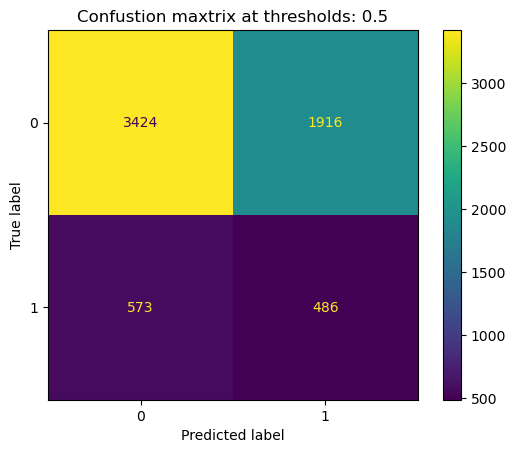

In [34]:
Y_predict = []
for y in predict:
    if y <= 0.5:
        Y_predict.append(0)
    else:
        Y_predict.append(1)
plt.clf()

#plt.figure(figsize=(9,6))
ConfusionMatrixDisplay.from_predictions(Y_predict,Y_test)#.im_.set_clim(2000, 8000)
plt.title("Confustion maxtrix at thresholds: " + str(0.5))
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/confusion_matrix.png")  
plt.show()

<Figure size 640x480 with 0 Axes>

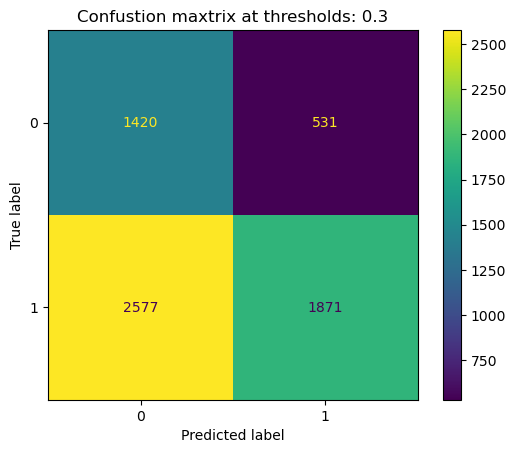

In [35]:
Y_predict = []
for y in predict:
    if y <= best_threshold:
        Y_predict.append(0)
    else:
        Y_predict.append(1)
plt.clf()

#plt.figure(figsize=(9,6))
ConfusionMatrixDisplay.from_predictions(Y_predict,Y_test)#.im_.set_clim(2000, 8000)
plt.title("Confustion maxtrix at thresholds: " + str(best_threshold)[:3])
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/confusion_matrix_best.png")  
plt.show()

<Figure size 640x480 with 0 Axes>

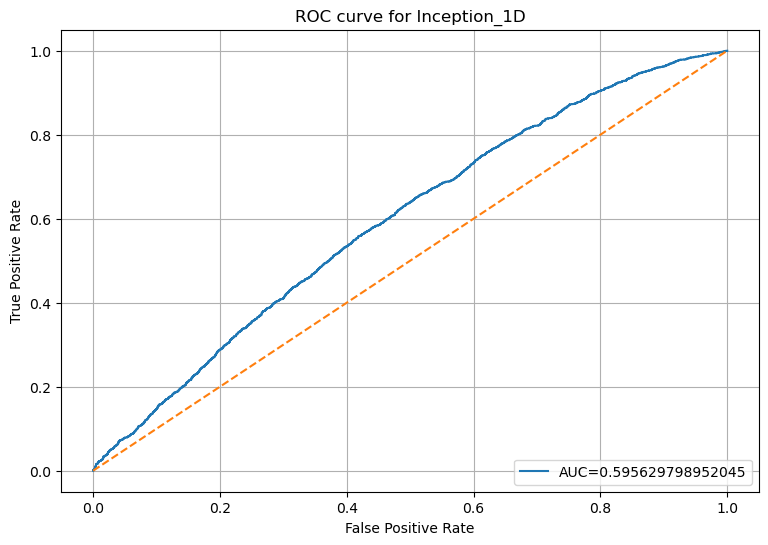

In [36]:
fpr, tpr, _ = roc_curve(Y_test,  predict)
auc = roc_auc_score(Y_test, predict)

plt.clf()
plt.figure(figsize=(9,6))
plt.title('ROC curve for '+ MODEL_NAME)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0,1],[0,1],ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc=4)
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/ROC.png")  
plt.show()

<Figure size 640x480 with 0 Axes>

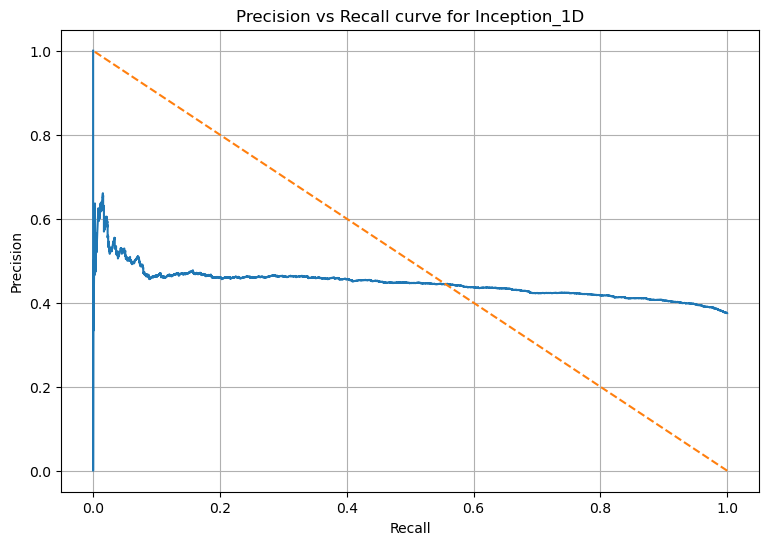

In [37]:
precision, recall, thresholds = precision_recall_curve(Y_test, predict)

plt.clf()
plt.figure(figsize=(9,6))
plt.title('Precision vs Recall curve for '+ MODEL_NAME)
plt.plot(recall, precision)
plt.plot([1,0],[0,1],ls="--")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/Precision_vs_Recall.png") 
plt.show()

# Parallelism

**No idea how to do it**

## Generate X and Y parallelism

In [38]:
# def Generate_X_Y_sample_parallelism(TYPE_OF_TASK, SUBJECT_BEGIN, SUBJECT_END, NUMBER_OF_TRIAL, NUMBER_TO_GENERATE,
#                         behaviour_data, eye_data):
#     behavior_grouped = behaviour_data.groupby(['Task Type', 'SID', 'Trial'])
#     eye_grouped = eye_data.groupby(['Task Type', 'SID', 'Trial'])

#     X = {}
#     Y = {}
#     for task_type in tqdm(TYPE_OF_TASK, desc='Task_type'):
#         #for each task_type
#         X[task_type] = []
#         Y[task_type] = []
        
#         for sid in tqdm(range(1)):#SUBJECT_BEGIN, SUBJECT_END), desc='Subject ID'):
#             #for each subject id
#             for i in range(1):#NUMBER_OF_TRIAL):
#                 #for each trial
                
#                 #if the data is not availible, it will raise an error
#                 try:
#                     behavior_temp = behavior_grouped.get_group((task_type,sid,i))
#                 except:
#                     continue
#                 eye_temp = eye_grouped.get_group((task_type,sid,i))

#                 for j in behavior_temp['Stimulus Time']:
#                     #for each stimulus time, j is the stimulus time
#                     for k in range(NUMBER_TO_GENERATE):
#                         # k is the number of sample to generate after the time j
#                         # the first samples is a positive sample, all sample after the first will the the negative sample

#                         ###########################
#                         #This code will generate X#
#                         ###########################
#                         begin = j + k*TIME_INTERVAL_EACH_SAMPLE
#                         end = begin + TIME_INTERVAL_EACH_SAMPLE
#                         eye_temp2 = eye_temp.query('Time >= @begin and Time <= @end')[NORMALIZE_FEATURES]
#                         if eye_temp2.shape[0] == 0:
#                             #This is an empty case
#                             continue

#                         if eye_temp2.isna().sum().sum() != 0:
#                             #This is an missing data case, drop the sample
#                             continue

#                         if eye_temp2.shape[0] == NUMBER_OF_TIME_SAMPLE + 1:
#                             #this is an extra sample case, drop the last one
# #                             print(eye_temp2.shape, ' sid:', sid, ' i:', i, ' j:', j)
#                             eye_temp2 = eye_temp2.drop(eye_temp2.tail(1).index)

#                         #this code to cut the sample into smaller channels
#                         #if NUMBER_OF_CHANNELS = 10, shape: (250,3,1) -> (25,3,10)
#                         eye_temp3 = []
#                         for l in range(NUMBER_OF_CHANNELS):
#                             #for each channel loop
#                             begin_l = l*NUMBER_OF_INTERVAL_EACH_CHANNEL
#                             end_l = begin_l + NUMBER_OF_INTERVAL_EACH_CHANNEL
#                             eye_temp3.append(eye_temp2[begin_l:end_l])
#                             #end l loop
#                         eye_temp2 = np.array(eye_temp3).swapaxes(0,2).swapaxes(0,1)
                        
                        
#                         X[task_type].append(eye_temp2)

#                         ###########################
#                         #This code will generate Y#
#                         ###########################
#                         if k == 0:
#                             Y_temp = [1]
#                         else:
#                             Y_temp = [0]
#                         Y[task_type].append(Y_temp)

#                         #end k loop
#                     # end j loop
#                 #end i loop
#             #end sid loop
            
#         X[task_type] = np.array(X[task_type])
#         Y[task_type] = np.array(Y[task_type])
#         #end task_type loop


#     return X, Y

In [39]:
# X_final, Y_final = Generate_X_Y_sample_parallelism(TASK_TYPE, 0, 53, 10, 3, behavior_df, eye_df_scaled)
# X_test, Y_test = Generate_X_Y_sample_parallelism(TASK_TYPE, 53, 58, 10, 3, behavior_df, eye_df_scaled)

# X_train = {}
# X_val = {}
# Y_train = {}
# Y_val = {}
# for task in TASK_TYPE:
#     X_train[task] = []
#     X_val[task] = []
#     Y_train[task] = []
#     Y_val[task] = []
#     X_train[task],X_val[task],Y_train[task],Y_val[task] = train_test_split(X_final[task],Y_final[task],
#                                                                            test_size=0.2, random_state=96, shuffle=True)
    
    
# for task in TASK_TYPE:
#     print("\nTask: ", task)
#     print(X_train[task].shape)
#     print(X_val[task].shape)
#     print(X_test[task].shape)
#     print(Y_train[task].shape)
#     print(Y_val[task].shape)
#     print(Y_test[task].shape)

## Create model

In [40]:
# model_parallel = {}

# for i, task in enumerate(TASK_TYPE):
#     with tf.device('/gpu:'+str(i)):
#         model_parallel[task] = create_model(X_train[task].shape, KERNEL_SIZE, STRIDES_SIZE, MAX_POOL, DROPOUT)




In [41]:
# for task in TASK_TYPE:
#     print(task)

In [42]:
# strategy = tf.distribute.MirroredStrategy()
# history = {}

# def training_parallel(X_train, Y_train, X_val, Y_val):
#     model = create_model(X_train.shape, KERNEL_SIZE, STRIDES_SIZE, MAX_POOL, DROPOUT)
#     history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), verbose=1, shuffle=False,)
#     return history

# with strategy.scope():
#     history['DPT'] = training_parallel(X_train['DPT'], Y_train['DPT'], X_val['DPT'], Y_val['DPT'])
#     history['MA'] = training_parallel(X_train['MA'], Y_train['MA'], X_val['MA'], Y_val['MA'])
#     history['PVT'] = training_parallel(X_train['PVT'], Y_train['PVT'], X_val['PVT'], Y_val['PVT'])
#     history['VWM'] = training_parallel(X_train['VWM'], Y_train['VWM'], X_val['VWM'], Y_val['VWM'])

In [43]:
# print('\a')
# print('\a')
# print('\a')
# print('\a')